In [16]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import matplotlib.pyplot as plt

from typing import Tuple, Sequence, Optional, List

# Create Gaussian blurs with varying widths and occluding bars

In [17]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
images = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

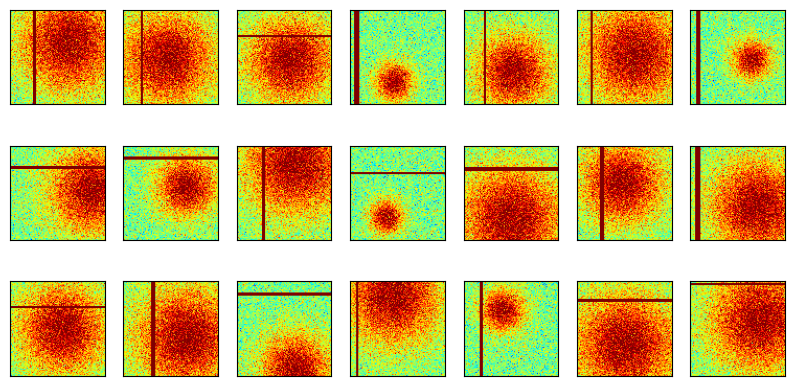

In [18]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create the DL model

In [19]:
def makeTheNet(in_channels: int = 1,
               out_channels: Tuple[int,int] = (6,4),
               kernel_size: Tuple[int,int]=(3,3),
               stride: Tuple[int,int]=(1,1),
               padding: Tuple[int,int]=(1,1)
               ):

  class GausNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.enc = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels = out_channels[0], kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        # nn.MaxPool2d(2,2),
        nn.AvgPool2d(2,2),
        nn.Conv2d(out_channels[0], out_channels[1], kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        # nn.MaxPool2d(2,2),
        nn.AvgPool2d(2,2)
      )
      # For odd inputs like 91×91, use a “+1” upsample each step:
      self.deconv1 = nn.ConvTranspose2d(out_channels[1], out_channels[0], kernel_size=(3,3), stride=(2,2), padding=(0,0))
      self.deconv2 = nn.ConvTranspose2d(out_channels[0], in_channels,kernel_size=(3,3), stride=(2,2), padding=(0,0))

    def forward(self, x):
      z = self.enc(x)
      y = F.relu(self.deconv1(z))
      # Guarantees exact recovery even with odd sizes:
      y = self.deconv2(y, output_size=x.size())
      return y

  net = GausNet()
  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
  return net, lossfun, optimizer

 
torch.Size([10, 1, 91, 91])


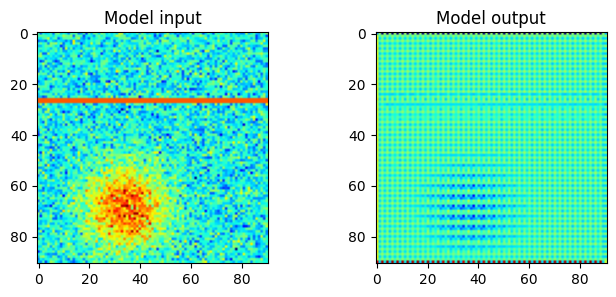

In [20]:
# test the model with one batch
# net,lossfun,optimizer = makeTheNet(in_channels=1,out_channels=(6,4),kernel_size=3, stride=1, padding=0)

net,lossfun,optimizer = makeTheNet(in_channels=1,out_channels=(6,4))

yHat = net(images[:10,:,:,:])

# check size of output
print(' ')
print(yHat.shape)

# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(images[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

plt.show()

In [21]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
   ConvTranspose2d-7            [-1, 6, 45, 45]             222
   ConvTranspose2d-8            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.15
Params size (MB): 0.00
Estimated Total Size (MB): 1.18
----------------------------------------------------------------


# Create a function that trains the model

In [22]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 500

  # create a new model
  net,lossfun,optimizer = makeTheNet(in_channels=1,out_channels=(6,4))

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(nGauss,size=32,replace=False)
    X = images[pics2use,:,:,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

In [23]:
# test the model on a bit of data
losses,net = function2trainTheModel()

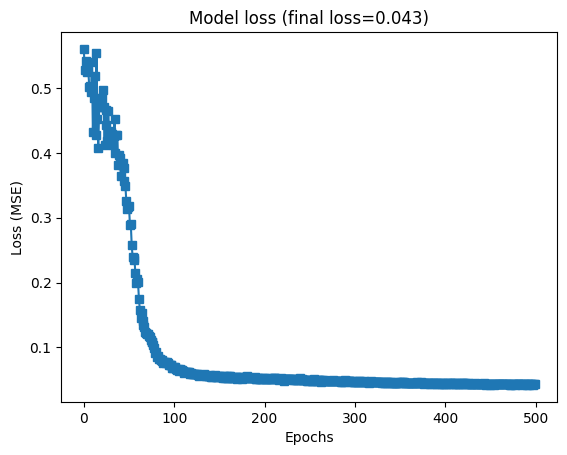

In [24]:
plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

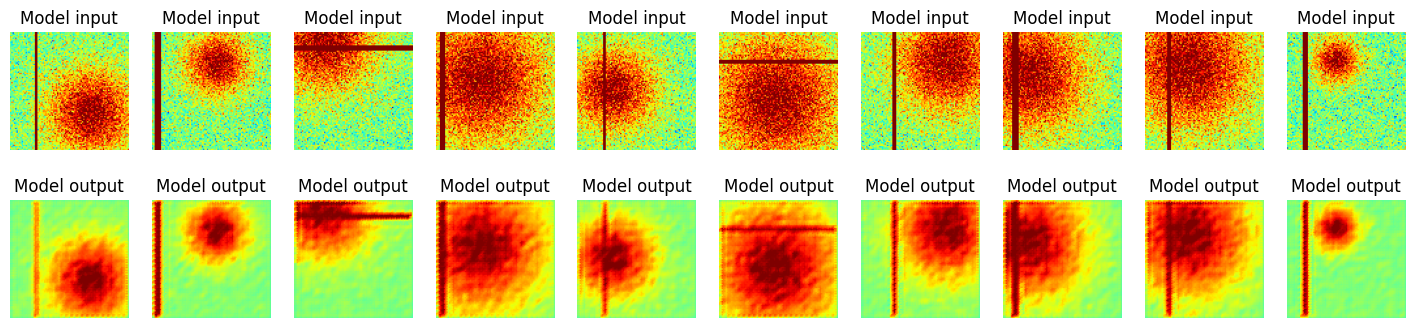

In [25]:
# visualize some images

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):

  G = torch.squeeze( X[i,0,:,:] ).detach()
  O = torch.squeeze( yHat[i,0,:,:] ).detach()

  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input')

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output')

plt.show()

# Test the model

In [26]:
# Generate random Gaussian blur images with occlusion

nGauss  = 500
imgSize = 47

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
images = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add an occlusion bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

# Save the model

In [30]:
torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/cnnae.pth')

# Load the saved model

In [32]:
net2,_,_ = makeTheNet(1,(6,4))
net2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/cnnae.pth"))

<All keys matched successfully>

# Test with the loaded model

In [33]:
net2.eval()

# pick a set of images at random
batch_samples = np.random.choice(nGauss,size=32,replace=False)
X = images[batch_samples,:,:,:]

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,X)


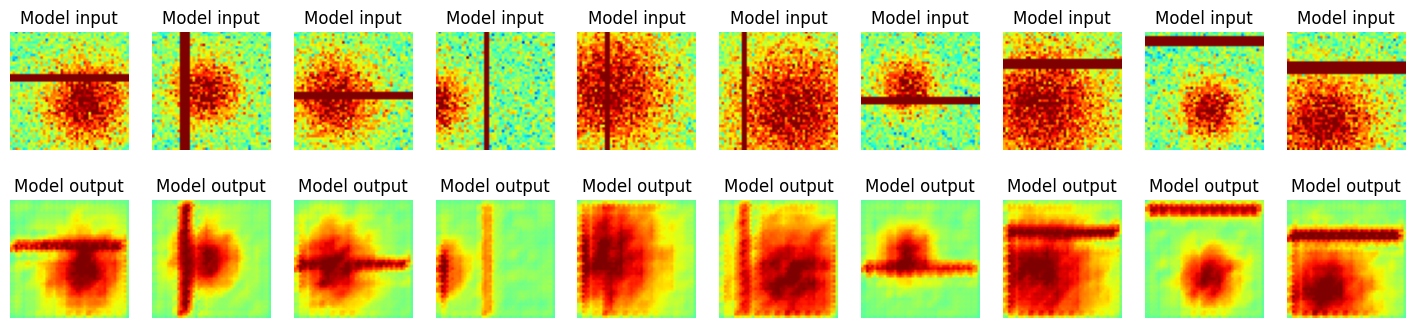

In [34]:
# visualize test results

batch_samples = np.random.choice(nGauss,size=32,replace=False)
X = images[batch_samples,:,:,:]
yHat = net2(X)

# specify sample images to be evaluated
sample_images = 10

fig,axs = plt.subplots(2,sample_images,figsize=(18,4))

for i in range(sample_images):

  actual_img = torch.squeeze( X[i,0,:,:] ).detach()
  result_img = torch.squeeze( yHat[i,0,:,:] ).detach()

  axs[0,i].imshow(actual_img,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input')

  axs[1,i].imshow(result_img,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output')

plt.show();